In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

## Import relevant libraries

In [2]:
# core system imports
import os

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import string
import random
import joblib
import itertools

from timeit import timeit
from unidecode import unidecode
import matplotlib.pyplot as plt

from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Dense, 
    Input, 
    LSTM, 
    Embedding, 
    Dropout, 
    GlobalMaxPool1D
)
from tensorflow.keras.models import Sequential

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    precision_recall_fscore_support
)

# Matplotlib config
%matplotlib inline
%alias_magic t timeit


Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


In [3]:
# check for available GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Location of the pipeline metadata store
_pipeline_root = '../pipeline/'

# Directory of the raw data files
_data_root = '../input/'

# Directory of the pretrained word embeddings
_embedding_root = '../input/embeddings'

_data_filepath = os.path.join(_data_root, "data.csv")

_stopwords_filepath = os.path.join(_data_root, "stopwords.txt")

_embedding_model_filepath = os.path.join(_embedding_root, "model_sg")
_pretrained_vectors_filepath = os.path.join(_embedding_root, "model_sg.wv.vectors.npy")
_neg_vectors_filepath = os.path.join(_embedding_root, "model_sg.trainables.syn1neg.npy")


In [5]:
# List input datasets in directory
os.listdir(_data_root)

# Word embeddings
print(os.listdir(_embedding_root))

['model_sg', 'model_sg.trainables.syn1neg.npy', 'model_sg.wv.vectors.npy']


## Load training and test data

In [6]:
# Read data from CSV file
data = pd.read_csv(_data_filepath)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       99 non-null     object 
 1   author_id  99 non-null     float64
 2   Label      99 non-null     object 
dtypes: float64(1), object(2)
memory usage: 2.4+ KB


In [8]:
data.head()

,text,author_id,Label
0,- @aishambuhari ta nemi babban sufeton 'yan sa...,7.970000e+17,Neutral
1,"""Duk dan Bokon da baida Ilimin Addini Annoba n...",2.290470e+09,Neutral
2,"""Duk mutumin da yayi tunanin bawa mutane ilimi...",1.071387e+09,Neutral
3,"""Duk wanda ya sabawa dokar kaucewa kamuwa daga...",1.260000e+18,Positive
4,"""Duk wanda ya san ya fito daga yankin da ake A...",1.039268e+09,Positive


In [9]:
# Read stop words
stopwords_list = list()

with open(_stopwords_filepath) as file:
    stopwords_list = [line.strip() for line in file.readlines()]

In [10]:
listToStr = ' '.join([str(word) for word in stopwords_list])
print(listToStr)

ta da ya sai ba yi na kuma ma ji cikin in ni wata wani ce tana don za sun amma ga ina ne mai suka wannan a ko lokacin su take shi yake yana ka ban ita tafi


In [11]:
# Read saved data from disk
def load_pickle(filename):
    data = joblib.load(filename)
    return(data)
    
# Save data to disk for future use
def save_pickle(data, filename):
    joblib.dump(data, filename)
    return True

In [12]:
# removing stopwords
def _apply_lowercase(text):
    text = [item for item in text if item not in stopwords_list]
    text = ''.join(text)
    return text

# removing stopwords
def _stopwords_removal(text):
    text = [item for item in text if item not in stopwords_list]
    text = ''.join(text)
    return text

# remove punctuations
def _punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

# Shuffle dataset
def _shuffle_dataset(dataset):
    dataset = shuffle(data)
    dataset = data.reset_index(drop=True)
    return dataset

In [13]:
# Change string to lower case
data['text'] = data['text'].apply(str.lower)

# Change label to lower case
data['Label'] = data['Label'].apply(str.lower)

# remove punctuations or special characters
data['text'] = data['text'].apply(_punctuation_removal)

# remove stopwords
data['text'] = data['text'].apply(_stopwords_removal)

# Shuffle the dataset to prevent bias:
data = _shuffle_dataset(data)

# Print head of the data
data.head()

,text,author_id,Label
0,ishmbuhri t nemi bbbn sufeton yn snd d y mgnc...,7.970000e+17,neutral
1,duk dn bokon d bid ilimin ddini nnob ne cikin ...,2.290470e+09,neutral
2,duk mutumin d yyi tunnin bw mutne ilimi d koy ...,1.071387e+09,neutral
3,duk wnd y sbw dokr kucew kmuw dg cutr coron zi...,1.260000e+18,positive
4,duk wnd y sn y fito dg ynkin d ke nnobr coron ...,1.039268e+09,positive


### Encode output lalbel

In [14]:
# make copy of dataframe
data_encoded = data.copy()

# create a label encoder
label_encoder = LabelEncoder()
label_encoder.fit(data_encoded['Label'])

data_encoded['label_encoded'] = label_encoder.transform(data_encoded['Label'])

data_encoded.head()

,text,author_id,Label,label_encoded
0,ishmbuhri t nemi bbbn sufeton yn snd d y mgnc...,7.970000e+17,neutral,1
1,duk dn bokon d bid ilimin ddini nnob ne cikin ...,2.290470e+09,neutral,1
2,duk mutumin d yyi tunnin bw mutne ilimi d koy ...,1.071387e+09,neutral,1
3,duk wnd y sbw dokr kucew kmuw dg cutr coron zi...,1.260000e+18,positive,2
4,duk wnd y sn y fito dg ynkin d ke nnobr coron ...,1.039268e+09,positive,2


### Split Dataset

+ Tranining: 70% of the dataset
+ Testing: 30% of dataset

In [15]:
list_classes = ["label_encoded"]

X_train, X_test, Y_train, Y_test = train_test_split(data_encoded["text"], data_encoded[list_classes], test_size=0.3, random_state = 1)

Y_train = Y_train.values
Y_test = Y_test.values

# Show dimension of the comments
X_train.shape, X_test.shape

((69,), (30,))

### Tokenize Sentences

To be able to train our model with a text data, we'd have to convert it into number form, for this we're going to use the Tokenizer module from Keras.preprocessing library

In [16]:
list_sentences_train = X_train.values
list_sentences_test = X_test.values

In [17]:
tokenizer = Tokenizer(lower=True)

tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [18]:
# size of training vocabulary (number of unique words)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

690

In [19]:
# print out a random sequence of text from the tokenized training data
print(random.choice(list_tokenized_train))

[134, 15, 424, 134, 39, 1, 49, 15, 425, 1, 426, 30, 7, 28, 8, 427, 428, 135, 429, 430, 49, 431, 432, 1, 136, 433, 1, 434, 435, 436, 39, 437, 1, 135, 438, 137, 439]


In [20]:
print(len(list_tokenized_train), 'train sequences')
print(len(list_tokenized_test), 'test sequences')

print('Average train sequence length: {}'.format(np.mean(list(map(len, list_tokenized_train)), dtype=int)))
print('Average test sequence length: {}'.format(np.mean(list(map(len, list_tokenized_test)), dtype=int)))

69 train sequences
30 test sequences
Average train sequence length: 18
Average test sequence length: 9


## Pad tokenized Sentences

You might have observed that the sentences are not of the same lengths, so we need to pad them with zeros (0's) so that the resulting array will have equal length.

We'd use `text` module from `keras.preprocessing` library

We'd use a max character of 300

In [21]:
maxlen = 300
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [22]:
print(X_train[:1])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0 

## Use pre-trained Word Embedding

In [23]:
# load saved genism model from disk
model_sg = Word2Vec.load(_embedding_model_filepath)

# load saved numpy vectors from disk
vectors = np.load(_pretrained_vectors_filepath)

# load a saved trainable numpy vectors from disk
vectors_neg = np.load(_neg_vectors_filepath)

In [24]:
# get vocabularies from saved model
vocabs = list()

for word, vocab_obj in model_sg.wv.vocab.items():
    vocabs.append(word)

# delete unused variables to free memory
del((word, vocab_obj))

In [25]:
# Check length of vectors
len(vectors), len(vectors_neg), len(vocabs)

(90451, 90451, 90451)

In [26]:
# create word embedding dictionary
embeddings = dict()

# zip words and their corresponding vectors
for i, (word,vector) in enumerate(zip(vocabs, vectors)):
    embeddings[word] = vector
    
# delete unused variables to free memory
del((i, word, vector))

In [27]:
num_tokens = vocab_size
embedding_dim = 300
hits = 0
misses = 0


# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        
print("Converted %d words (%d misses)" % (hits, misses))

Converted 232 words (457 misses)


## Build Model

In [28]:
model = Sequential()

In [29]:
model.add(Input(shape=(maxlen, )))

In [30]:
embed_size = 300
model.add(Embedding(vocab_size, embed_size, weights=[embedding_matrix], trainable=False))

In [31]:
model.add(LSTM(60, return_sequences=True,name='lstm_layer'))

In [32]:
model.add(GlobalMaxPool1D())

In [33]:
model.add(Dropout(0.1))

In [34]:
model.add(Dense(50, activation="relu"))

In [35]:
model.add(Dropout(0.1))

In [36]:
model.add(Dense(3, activation="softmax"))

In [37]:
model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          207000    
_________________________________________________________________
lstm_layer (LSTM)            (None, 300, 60)           86640     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

### Create plot for model architecture

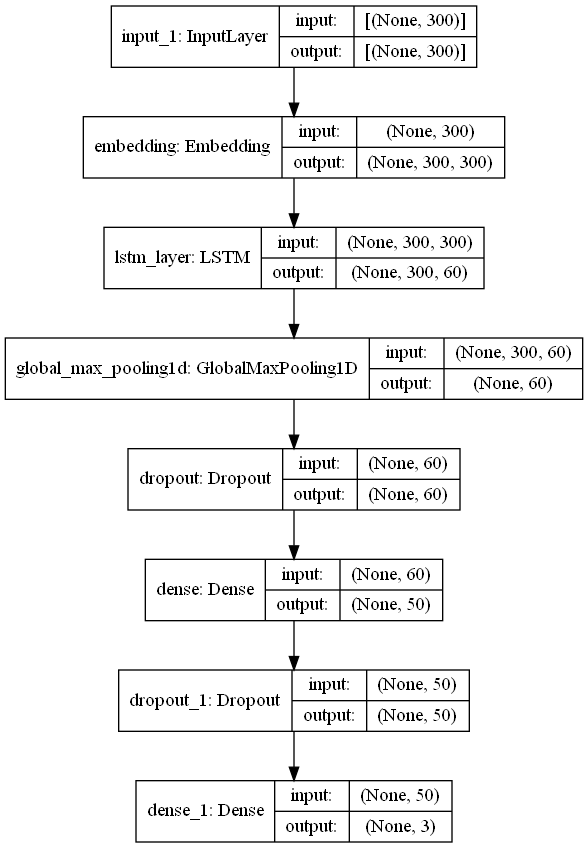

In [39]:
# Plot model
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file,
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir="TB",
                          expand_nested=True,
                          dpi=96
                         )

### Train model

In [40]:
batch_size = 16
epochs = 10
model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, Y_test))

Epoch 1/10
5/5 [==============================] - 4s 110ms/step - loss: 1.0335 - accuracy: 0.6232 - val_loss: 1.0104 - val_accuracy: 0.6333
Epoch 2/10
5/5 [==============================] - 0s 38ms/step - loss: 0.8854 - accuracy: 0.6957 - val_loss: 0.9818 - val_accuracy: 0.6333
Epoch 3/10
5/5 [==============================] - 0s 23ms/step - loss: 0.8136 - accuracy: 0.6957 - val_loss: 1.0107 - val_accuracy: 0.6333
Epoch 4/10
5/5 [==============================] - 0s 22ms/step - loss: 0.8034 - accuracy: 0.6957 - val_loss: 0.9991 - val_accuracy: 0.6333
Epoch 5/10
5/5 [==============================] - 0s 21ms/step - loss: 0.7756 - accuracy: 0.6957 - val_loss: 0.9801 - val_accuracy: 0.6333
Epoch 6/10
5/5 [==============================] - 0s 19ms/step - loss: 0.7866 - accuracy: 0.6957 - val_loss: 0.9635 - val_accuracy: 0.6333
Epoch 7/10
5/5 [==============================] - 0s 19ms/step - loss: 0.7524 - accuracy: 0.6957 - val_loss: 0.9578 - val_accuracy: 0.6333
Epoch 8/10
5/5 [==========

### Evaluate model

In [41]:
score, accuracy = model.evaluate(X_test, Y_test, verbose = 1, batch_size = 32)
print("score: %.4f" % (score))
print("acc: %.4f" % (accuracy))

1/1 [==============================] - 0s 25ms/step - loss: 0.9218 - accuracy: 0.6333
score: 0.9218
acc: 0.6333


In [42]:
predictions = model.predict(X_test, batch_size=32, verbose=1)

1/1 [==============================] - 0s 268ms/step


In [43]:
predictions[:3]

array([[0.18938278, 0.30448556, 0.50613165],
       [0.07772788, 0.13101234, 0.7912597 ],
       [0.1096477 , 0.15914932, 0.731203  ]], dtype=float32)

In [44]:
# classify the input image then find the indexes of the two class
# labels with the *largest* probability
index = 0

print("[INFO] classifying tweet {}".format(index))

proba = predictions[index]
idxs = np.argsort(proba)[::-1][:2]

# loop over the indexes of the high confidence class labels
for (i, j) in enumerate(idxs):
    # build the label and draw the label on the image
    label = "{}: {:.2f}%".format(list_classes[j], proba[j] * 100)
    
# show the probabilities for each of the individual labels
for (label, p) in zip(list_classes, proba):
    print("{}: {:.2f}%".format(label, p * 100))


[INFO] classifying tweet 0


IndexError: list index out of range

In [ ]:
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    print("For threshold: ", val)
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(Y_test, pred, average='micro')
    recall = recall_score(Y_test, pred, average='micro')
    f1 = f1_score(Y_test, pred, average='micro')
    accuracy = accuracy_score(Y_test, pred, normalize=True)

    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}, Accuracy: {:.4f}".format(precision, recall, f1, accuracy))
